# Arranging cupcakes in a plate using difference of convex optimization

Consider the problem of arranging a fixed number of cupcakes in a round plate. This problem may be cast as the following optimization problem.

    We wish to maximize the minimum separation between any two cupcakes under the following constraints.
    1. the minimum separation definition is greater than twice the cupcake radius, and
    2. the center of the cupcake is sufficiently within the plate.

**Goal of this post**: This optimization problem will turn out to be non-convex. Obtaining global optima of such problems is known to be computationally hard. This post discusses a difference of convex program-based solution to this problem. It utilizes the structure in the problem to setup a series of convex optimization problems, whose solutions converge to a local optimum of the optimization problem. By utilizing convex optimization, we obtain computationally efficient solutions.

### Optimization problem

Let $N$ be the number of cupcakes. For simplicity, we assume cupcakes to be disks of radius $r$ and the plate to be a larger disk of radius $R$. Formally, we write this optimization problem as follows:
\begin{align}
\begin{array}{rll}
\underset{s, x_c^{(1)}, \ldots, x_c^{(N)}}{\mathrm{maximize}}&\quad s\\
\text{subject to}&\quad s \geq 2r \\
&\quad {\Vert x_c^{(i)}\Vert}_2\leq R - r,&\text{ for }i\in \{1,\ldots, N\}\\
&\quad {\Vert x_c^{(i)} - x_c^{(j)}\Vert}_2\geq s,&\text{ for }i,j\in \{1,\ldots, N\}, i<j\\
\end{array}
\end{align}

The decision variables are the cupcake centers as $x_c^{(i)}\in \mathbb{R}^2,\ i\in \{1,\ldots,N\}$, and the minimum separation between any two cupcakes as $s\in \mathbb{R}$. We assume the round plate to be a circle of radius $R$ centered at the origin. While the first two constraints encode the above requirements, the third constraint expresses the minimum separation definition in the "epigraph form". It guarantees that the separation between the cupcakes can not be smaller than $s$, which is subsequently maximized as desired.

### Non-convexity of the optimization problem

Note that the objective, the first constraint, and the second constraint are convex. However, the third constraint is a *reverse convex constraint*. Reverse convexity refers to the fact that the complement of the second constraint (${\Vert x_c^{(i)} - x_c^{(j)}\Vert}_2< 2r$) is a convex constraint. 

Optimization under reverse convex constraints are ubquitous. For example, consider the optimization problems involving obstacle avoidance of convex obstacles or spreading vectors on a unit sphere equidistantly.

# Solving this problem via CVXPY

### Packages

In [1]:
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt

### Problem parameters

In [2]:
R_platter = 16;
r_cupcake = 2.5;
n_cupcake = 30;

### Drawing plate and cupcakes

In [3]:
# Color (RGB) for the platter
color_for_platter = np.array([0.9,0.9,0.9]);
# List of colors for the cupcakes (randomly chosen)
color_vec = list(np.random.rand(n_cupcake, 3))
color_vec.append(color_for_platter)

# Function for drawing circle
def draw_circle(center, radius, is_new, color_value):
    # Scaling for the axis
    scale_axis = 1.2
    # Define a circle
    circle_obj = plt.Circle(center, radius, color=color_value);
    if is_new:
        # Alternatively, use fig = plt.figure();ax = fig.add_subplot(111)
        fig, ax = plt.subplots()
        # Set limits on the x-axis and y-axis
        ax.set_xlim([-scale_axis*radius, scale_axis*radius])
        ax.set_ylim([-scale_axis*radius, scale_axis*radius])
        # Set aspect ratio to be 1
        ax.set_aspect(1)
    else:
        fig = plt.gcf()
        ax = fig.gca()
    ax.add_artist(circle_obj)    

# Function for drawing cupcakes on the platter given the cupcake locations    
def draw_plate_and_cupcakes(cupcake_locations, r_cupcake, R_platter, color_vec):
    # Draw the plate first
    draw_circle([0,0], R_platter, 1, list(color_vec[-1]))
    # Draw the cupcakes
    for indx in range(cupcake_locations.shape[1]):
        center = cupcake_locations[:,indx]
        #print(indx, center)
        draw_circle(center, r_cupcake, 0, list(color_vec[indx]))

## Step 1: Construct an initial solution (need not be even feasible!)

We construct an initial solution by placing the cupcakes randomly within our plate. They may overlap (it is not even a feasible starting solution!).

Using a polar coordinate frame to locate the cupcakes, our initial solution is randomly generated by sampling the interval $[0,2\pi]$ (under uniform distribution) for the angle and sampling the interval $[0,R]$ (under uniform distribution) for the distance from the center.

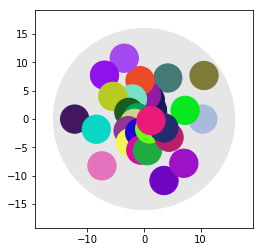

In [4]:
# Sample the unit circle for
theta_vec = np.linspace(0, 2*np.pi, n_cupcake+1);
theta_vec = theta_vec[0:len(theta_vec)-1];
# Initial guess: Randomly place cupcakes within the plate
r_vec = (R_platter - r_cupcake)* np.array(np.random.rand(1,n_cupcake));
# Create the matrix of initial locaitons by hand. Recall that numpy does elementwise multiplication by default.
x_initial = np.vstack([r_vec, r_vec]) * np.vstack([np.cos(theta_vec), np.sin(theta_vec)]);
# Display the initial solution
draw_plate_and_cupcakes(x_initial, r_cupcake, R_platter, color_vec)

## Step 2: Difference of convex programming-based solution

### Step 2a: Define the convex subproblem by linearizing the non-convex parts

We consider the infeasible start solution to the difference of convex programs. This is described in Algorithm 3.1 as the penalty convex-concave procedure.

The original optimization problem was
\begin{align}
\begin{array}{rll}
\underset{s, x_c^{(1)}, \ldots, x_c^{(N)}}{\mathrm{maximize}}&\quad s\\
\text{subject to}&\quad s \geq 2r \\
&\quad {\Vert x_c^{(i)}\Vert}_2\leq R - r,&\text{ for }i\in \{1,\ldots, N\}\\
&\quad {\color{red} {{\Vert x_c^{(i)} - x_c^{(j)}\Vert}_2\geq s}},&\text{ for }i,j\in \{1,\ldots, N\}, i<j\\
\end{array}
\end{align}

At each iteration, we linearize the constraint highlighted in red obtaining a convex relaxation. Consider the equivalent quadratic constraint (squaring both sides),
$${\left({x_c^{(i)} - x_c^{(j)}}\right)}^\top\left({x_c^{(i)} - x_c^{(j)}}\right)\geq s^2$$

This constraint can be written as a difference of convex constraint as follows
$$\underbrace{s^2}_{\text{convex}} - \underbrace{{\left({x_c^{(i)} - x_c^{(j)}}\right)}^\top\left({x_c^{(i)} - x_c^{(j)}}\right)}_{\text{convex}}\leq 0$$

Let $y_c^{(\cdot)}$ denote the current solution iterate. Then, we linearize the non-convex part of the above constraint about $y_c^{(\cdot)}$ to obtain the convex constraint
$$\underbrace{s^2}_{\text{convex}} - \left({\underbrace{{\left({y_c^{(i)} - y_c^{(j)}}\right)}^\top\left({y_c^{(i)} - y_c^{(j)}}\right) + 2{\left({y_c^{(i)} - y_c^{(j)}}\right)}^\top\left({x_c^{(i)} - y_c^{(i)}}\right) - 2{\left({y_c^{(i)} - y_c^{(j)}}\right)}^\top\left({x_c^{(j)} - y_c^{(j)}}\right)}_{\text{affine}}}\right)\leq 0$$
**NOTE**: The indicies used follows from careful differentiation of the quadratic term. See [https://en.wikipedia.org/wiki/Matrix_calculus#Derivatives_with_vectors](https://en.wikipedia.org/wiki/Matrix_calculus#Derivatives_with_vectors). 

#### Original convex subproblem

Since the affine approximation is a guaranteed underapproximation of the convex curve, replacing the reverse convex constraint with the affine approximation produces the following convex restriction.
\begin{align}
\begin{array}{rll}
\underset{s, x_c^{(1)}, \ldots, x_c^{(N)}}{\mathrm{minimize}}&\quad -s\\
\text{subject to}&\quad s \geq 2r \\
&\quad {\Vert x_c^{(i)}\Vert}_2\leq R - r,&\text{ for }i\in \{1,\ldots, N\}\\
&\quad {s^2} - {\left({y_c^{(i)} - y_c^{(j)}}\right)}^\top\left({y_c^{(i)} - y_c^{(j)}}\right) - 2{\left({y_c^{(i)} - y_c^{(j)}}\right)}^\top\left({x_c^{(i)} - y_c^{(i)}}\right) &\\
&\qquad\qquad+ 2{\left({y_c^{(i)} - y_c^{(j)}}\right)}^\top\left({x_c^{(j)} - y_c^{(j)}}\right) \leq 0,&\text{ for }i,j\in \{1,\ldots, N\}, i<j
\end{array}
\end{align}
In other words, any $x_c^{(\cdot)}$ that satisfies this constraint is guaranteed to satisfy the original difference of convex problem.

#### Relaxed convex subproblem for infeasible solution start

Accounting for an infeasible start, we also relax the affine approximation constraint via *non-negative* slack variables. 
$$s^2 - {\left({y_c^{(i)} - y_c^{(j)}}\right)}^\top\left({y_c^{(i)} - y_c^{(j)}}\right) + 2{\left({y_c^{(i)} - y_c^{(j)}}\right)}^\top\left({x_c^{(i)} - y_c^{(i)}}\right) - 2{\left({y_c^{(i)} - y_c^{(j)}}\right)}^\top\left({x_c^{(j)} - y_c^{(j)}}\right) \leq \tau_{ij}, \quad \tau_{ij} \geq 0$$
At every iteration, we minimize the $\ell_1$-norm of the slack variables with increasing priority. Thus, we optimize the following convex subproblem
\begin{align}
\begin{array}{rll}
\underset{s, x_c^{(1)}, \ldots, x_c^{(N)},\overline{\tau}}{\mathrm{minimize}}&\quad -s + \mu {\Vert \overline{\tau}\Vert}_1\\
\text{subject to}&\quad s \geq 2r \\
&\quad {\Vert x_c^{(i)}\Vert}_2\leq R - r,&\text{ for }i\in \{1,\ldots, N\}\\
&\quad {s^2} - {\left({y_c^{(i)} - y_c^{(j)}}\right)}^\top\left({y_c^{(i)} - y_c^{(j)}}\right) - 2{\left({y_c^{(i)} - y_c^{(j)}}\right)}^\top\left({x_c^{(i)} - y_c^{(i)}}\right) &\\
&\qquad\qquad+ 2{\left({y_c^{(i)} - y_c^{(j)}}\right)}^\top\left({x_c^{(j)} - y_c^{(j)}}\right) \leq \tau_{ij},&\text{ for }i,j\in \{1,\ldots, N\}, i<j\\
&\quad \tau_{ij} \geq 0,&\text{ for }i,j\in \{1,\ldots, N\}, i<j\\
\end{array}
\end{align}
where $\overline{\tau}$ is a $\frac{N(N-1)}{2}$-dimensional vector of slack variables $\tau_{ij}$. For large values of $\mu$, we assign more priority to making the slack variables as small as possible.

Due to the relaxation of the linearized convex constraint, the convex subproblem is **no longer** a convex restriction of the original difference of convex problem.

In [5]:
# Parameters of the problem
mu = cvx.Parameter(nonneg=True)
yc = cvx.Parameter((2, n_cupcake))
# Variables of the problem (with non-negative constraints enforced)
sep = cvx.Variable(1, nonneg=True)
xc = cvx.Variable((2, n_cupcake))
tau = cvx.Variable((int(n_cupcake * (n_cupcake - 1)/2), 1), nonneg=True)
# Objective
objective = -sep + mu * cvx.sum(tau)
# Constraints
constraints = [sep >= 2*r_cupcake,
               cvx.norm(xc,p=2,axis=0) <= R_platter - r_cupcake]
slack_indx = 0
for indx_j in range(1, n_cupcake):
    for indx_i in range(indx_j):
        constraints += [np.power(sep,2) - (yc[:, indx_i] - yc[:, indx_j]).T@(yc[:, indx_i] - yc[:, indx_j]) 
                        - 2 * (yc[:, indx_i] - yc[:, indx_j]).T@(xc[:, indx_i] - yc[:, indx_i]) 
                        + 2 * (yc[:, indx_i] - yc[:, indx_j]).T@(xc[:, indx_j] - yc[:, indx_j]) <= tau[slack_indx]]
        slack_indx += 1
# Setting up the relaxed convex subproblem
prob = cvx.Problem(cvx.Minimize(objective), constraints)

### Step 2b: Define the parameters for the penalty convex-concave procedure

The convex-concave procedure has the following parameters:
1. `slack_tol` --- Tolerance for the sum of slack variables (should be very small)
1. `cost_diff_tol` --- Tolerance for the change in cost (should be very small)
1. `max_iter` --- Maximum number of iterations
1. `mu_initial` --- Starting value for the parameter $\mu$
1. `mu_scaling` --- Scaling factor for $\mu$ at every iteration
1. `mu_max` --- Maximum value for $\mu$

The priority variable $\mu$ follows the geometric progression 
\begin{align}
\mu^{(i)} = \begin{cases}{\begin{array}{ll}
\mu_\mathrm{iter}(i) & \mu_\mathrm{iter}(i) \leq \mu_\mathrm{max} \\
\mu_\mathrm{max} & \text{otherwise} \end{array}}\end{cases}
\end{align}
with $\mu_\mathrm{iter}(i) = \mu_\text{initial} {(\mu_\text{scaling})}^i$. This can be compactly written as
\begin{align}
\mu^{(i)} = \mathrm{min}(\mu_\mathrm{iter}(i),\mu_\mathrm{max})
\end{align}

In addition, we provide a `verbose` parameter to visualize the solution process.

|Option | Result |
| --- | --- |
|0 | No output|
|1 | Only text output|
|2 | Text and plot output|

In [6]:
# Tolerances for exit condition
slack_tol = 1e-8;
cost_diff_tol = 1e-5;
# Number of iterations
max_iter = 200;
# Parameters for mu (scaling of the slack)
mu_initial = 1;
mu_scaling = 1.1;
mu_max = 1e4;
# Verbosity of the penalty convex-concave procedure
# 0 --- No output
# 1 --- Only text output
# 2 --- Text and plot output
verbose = 2

## Step 3: Iterate through the penalty convex-concave procedure

The convex-concave procedure consists of the following steps:
1. Solve the convex subproblem for a fixed priority variable $\mu^{(k)}$ and the current solution estimate $y_c^{(\cdot)}$ at iteration $k$.
2. Compute $\mu^{(k+1)}$ using the update rule.
3. Repeat steps 1 and 2 till the following conditions are met OR maximum number of iterations
\begin{align}
    s^{(k+1)} - s^{(k)} \leq \text{cost_diff_tol}, \quad  \left\vert {\sum_{ij} \tau_{ij}^{(k+1)} - \sum_{ij} \tau_{ij}^{(k)}}\right\vert \leq \text{slack_tol}
\end{align}

  1. Status: optimal | mu: 1.0e+00 | Slack sum: 3.178e+02 (<1e-08) | Cost change: inf (<1e-05) |
     Violation count: 12 | Solution time (total): 2.458e-02 seconds


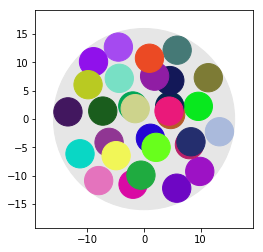

  2. Status: optimal | mu: 1.1e+00 | Slack sum: 1.275e+02 (<1e-08) | Cost change: 8.898e-10 (<1e-05) |
     Violation count: 5 | Solution time (total): 2.393e-02 seconds


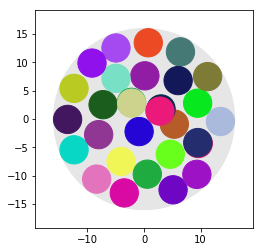

  3. Status: optimal | mu: 1.2e+00 | Slack sum: 7.075e+01 (<1e-08) | Cost change: 1.133e-09 (<1e-05) |
     Violation count: 3 | Solution time (total): 2.172e-02 seconds


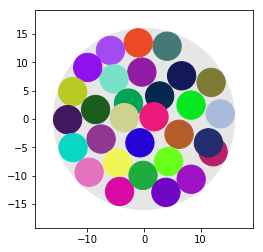

  4. Status: optimal | mu: 1.3e+00 | Slack sum: 1.843e+01 (<1e-08) | Cost change: 1.903e-10 (<1e-05) |
     Violation count: 1 | Solution time (total): 2.439e-02 seconds


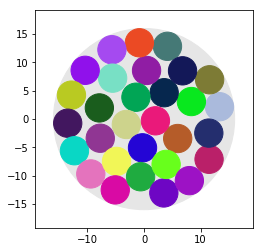

  5. Status: optimal | mu: 1.5e+00 | Slack sum: 6.079e-09 (<1e-08) | Cost change: 7.674e-02 (<1e-05) |
     Violation count: 0 | Solution time (total): 2.190e-02 seconds


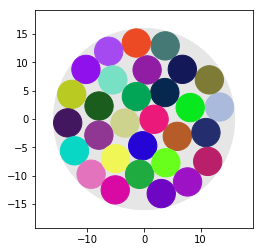

  6. Status: optimal | mu: 1.6e+00 | Slack sum: 4.635e-09 (<1e-08) | Cost change: 3.187e-02 (<1e-05) |
     Violation count: 0 | Solution time (total): 1.838e-02 seconds


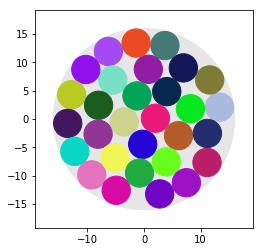

  7. Status: optimal | mu: 1.8e+00 | Slack sum: 4.512e-10 (<1e-08) | Cost change: 1.246e-02 (<1e-05) |
     Violation count: 0 | Solution time (total): 2.058e-02 seconds


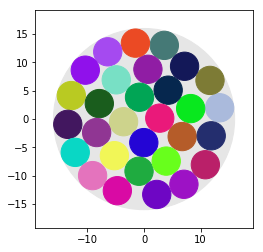

  8. Status: optimal | mu: 1.9e+00 | Slack sum: 9.539e-09 (<1e-08) | Cost change: 3.782e-02 (<1e-05) |
     Violation count: 0 | Solution time (total): 2.137e-02 seconds


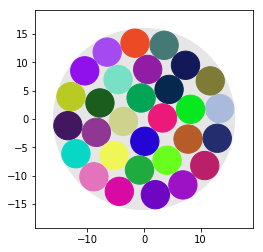

  9. Status: optimal | mu: 2.1e+00 | Slack sum: 2.874e-09 (<1e-08) | Cost change: 1.436e-02 (<1e-05) |
     Violation count: 0 | Solution time (total): 1.988e-02 seconds


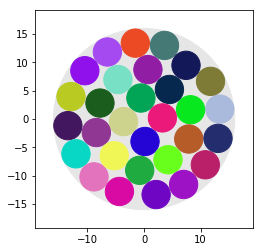

 10. Status: optimal | mu: 2.4e+00 | Slack sum: 3.216e-09 (<1e-08) | Cost change: 4.177e-04 (<1e-05) |
     Violation count: 0 | Solution time (total): 3.920e-02 seconds


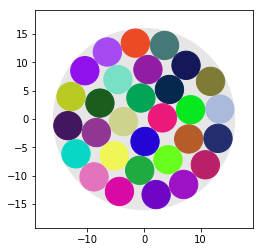

 11. Status: optimal | mu: 2.6e+00 | Slack sum: 2.067e-09 (<1e-08) | Cost change: 5.905e-07 (<1e-05) |
     Violation count: 0 | Solution time (total): 2.031e-02 seconds


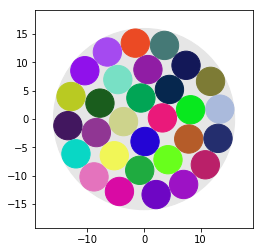

In [7]:
mu.value = mu_initial
yc.value = x_initial
iter_count = 0;
while True:
    iter_count += 1
    # Solve the problem with the given mu and yc values
    prob.solve(solver=cvx.ECOS)    
    
    # Compute the cost difference between iterations
    if iter_count == 1:
        # If the first iteration, set the difference to be infinity
        cost_diff = float("inf")
    else:
        # Otherwise, compute the actual difference
        cost_diff = abs(sep.value - cost_prev)
    cost_prev = sep.value
    # Compute the total sum of slack variables
    slack_sum = np.sum(tau.value)
    
    # Based on verbosity, plot/print information about the iteration
    if verbose >= 1:
        violation_count = 0
        for indx_j in range(1, n_cupcake):
            for indx_i in range(indx_j):
                if cvx.norm(xc.value[:,indx_i] - xc.value[:, indx_j], p=2).value < 2*r_cupcake:
                    violation_count += 1
        print("%3d. Status: %s | mu: %1.1e | Slack sum: %1.3e (<%1.0e) | Cost change: %1.3e (<%1.0e) |\n"\
              "     Violation count: %d | Solution time (total): %1.3e seconds" % (iter_count, prob.status,  
              mu.value, slack_sum, slack_tol, cost_diff, cost_diff_tol, violation_count,
              prob.solver_stats.setup_time + prob.solver_stats.solve_time))
        
    if verbose >= 2:
        draw_plate_and_cupcakes(xc.value, r_cupcake, R_platter, color_vec)
        plt.show()

    # Exit the iteration only if tolerances are met OR maximum iterations have been reached
    if ((cost_diff <= cost_diff_tol) and (slack_sum <= slack_tol)) or (iter_count == max_iter):
        break
    mu.value = min(mu.value * mu_scaling, mu_max)
    yc.value = xc.value

## Final result

We plot the final cupcake arrangement as well as report the associated minimum separation.

Minimum separation (boundary to boundary) between two cupcakes: 0.174


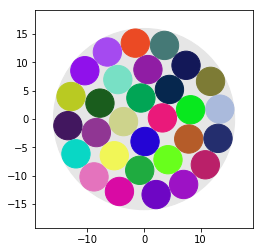

In [8]:
print("Minimum separation (boundary to boundary) between two cupcakes: %1.3f" % (sep.value - 2*r_cupcake))
draw_plate_and_cupcakes(xc.value, r_cupcake, R_platter, color_vec)